# Stitched inversion of 2D field data

In [1]:
import numpy as np
from simpeg.electromagnetics import natural_source as nsem
from simpeg import maps
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.gridspec as gridspec
from simpeg.utils import plot_1d_layer_model
from discretize import TensorMesh
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)

## Step 1: Import Yellowstone MT data in `mth5` format

In [2]:
from mtpy import MTCollection
mc = MTCollection()
mc.open_collection("../../data/transfer_functions/yellowstone_mt_collection.h5")

/Users/sgkang09/Project/mtpy-v2/mtpy/modeling/simpeg/recipes/inversion_1d.py:19: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG.electromagnetics import natural_source as nsem


In [3]:
# Extract 2D line
ii = 1
kk = -7
inds_sr = ['SR' in station for station in mc.dataframe['station'].values]
station_ids = mc.dataframe['station'].values[inds_sr][ii:kk]
lat = mc.dataframe['latitude'].values[inds_sr][ii:kk]
lon = mc.dataframe['longitude'].values[inds_sr][ii:kk]

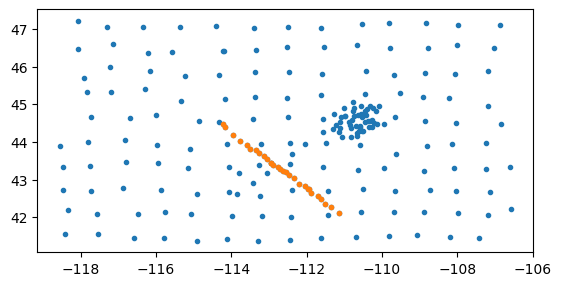

In [4]:
plt.plot(mc.dataframe['longitude'].values, mc.dataframe['latitude'].values, '.')
plt.plot(lon, lat, '.')
plt.gca().set_aspect(1)

## Step 2: Visulize transfer function at each station

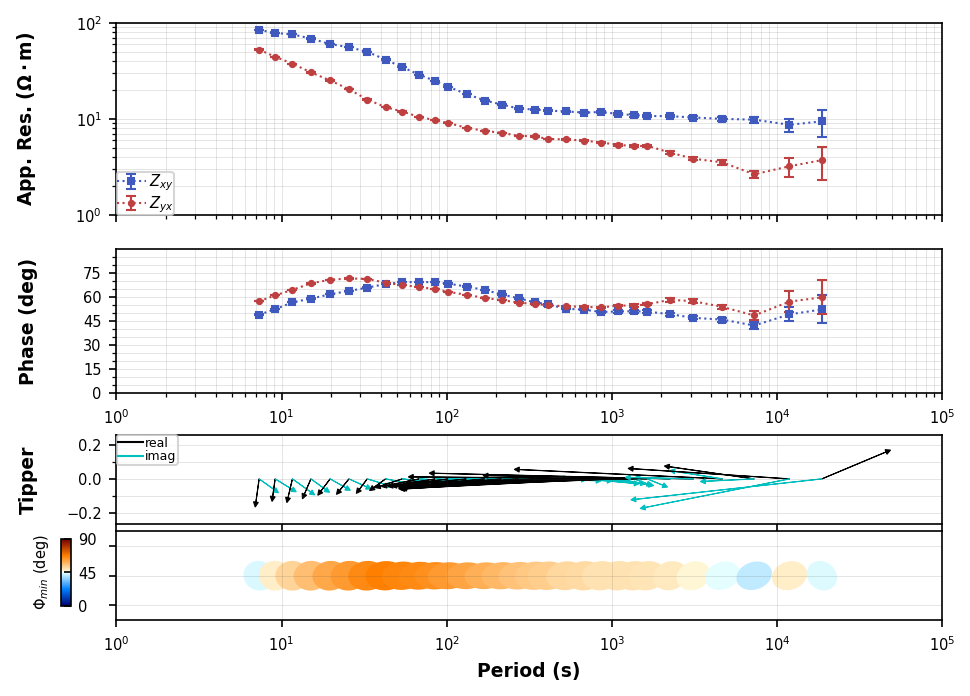

interactive(children=(Select(description='name', options=('SR205', 'SR209', 'SR212', 'SR216', 'SR220', 'SR222'…

In [5]:
from ipywidgets import widgets, interact
station_names = mc.dataframe.station.values
def foo(name, component):
    tf = mc.get_tf(name)
    tf.plot_mt_response()
Q = interact(
    foo, 
    name=widgets.Select(options=station_ids),
    component=widgets.RadioButtons(options=['xy', 'yx', 'det'], value='xy')
)

## Step 3: Design a 1D vertical mesh

In [6]:
from geoana.em.fdem import skin_depth
tf = mc.get_tf(station_ids[0])
f_min = tf.frequency.min()
f_max = tf.frequency.max()
z_max = skin_depth(f_min, 1e-2) * 1
print (z_max/1e3)
z_min = skin_depth(f_max, 1e-2) / 5
print (z_min/1e3)

24:10:14T19:57:44 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR205. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.
688.6936173947421
2.7223014526313616


In [7]:
n_layer = 21
z_factor = 1.2
layer_thicknesses_inv = z_min*z_factor**np.arange(n_layer-1)[::-1]
print (z_max/1e3, np.sum(layer_thicknesses_inv)/1e3)

688.6936173947421 508.22101256083084


## Step 4: Run separate 1D inversions

In [8]:
def run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=False,
    p_s=2,
    p_z=2
    
):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, reference_model=mref, mapping=maps.IdentityMap(mesh_inv))

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)
    if use_irls:
        reg.norms = np.c_[p_s, p_z]
        # Reach target misfit for L2 solution, then use IRLS until model stops changing.
        IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

        # The directives are defined as a list.
        directives_list = [
            IRLS,
            starting_beta,
            save_dictionary,
        ]
    else:
        # The directives are defined as a list.
        directives_list = [
            starting_beta,
            beta_schedule,
            target_misfit,
            save_dictionary
        ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, inv_prob.phi_d

In [9]:
resistivity_models = []
phid_s = []
# Relative error for apparent resistivity
relative_error_rho = 0.05
# Floor for phase
floor_phase = 2.
rho_0  = 100.

rho_ref = 100.
for i_station in range(len(station_ids)):
    tf = mc.get_tf(station_ids[i_station])
    dobs = np.c_[tf.Z.res_det, tf.Z.phase_det].flatten()
    dobs_error = np.c_[tf.Z.res_error_det, tf.Z.phase_error_det].flatten()    

    frequencies = tf.frequency
    rho_app = dobs.reshape((len(frequencies), 2))[:,0]
    phase = dobs.reshape((len(frequencies), 2))[:,1]
    standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten() 
    recovered_model, phi_d = run_fixed_layer_inversion(
        dobs,
        standard_deviation,
        rho_0,
        rho_ref,
        maxIter=5,
        maxIterCG=30,
        alpha_s=1e-5,
        alpha_z=1,
        beta0_ratio=1,
        coolingFactor=2,
        coolingRate=1,
        chi_factor=1
    )
    phid_s.append(phi_d)
    resistivity_models.append(1./np.exp(recovered_model))

24:10:14T19:57:44 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR205. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.

Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.03e+05  1.25e+06  0.00e+00  1.25e+06    6.58e+05      0              
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Mat

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.45e+06  4.72e+07  0.00e+00  4.72e+07    2.66e+07      0              
   1  2.73e+06  6.72e+06  7.18e-01  8.68e+06    3.49e+06      0              
   2  1.36e+06  1.36e+06  1.35e+00  3.21e+06    6.26e+05      0   Skip BFGS  
   3  6.82e+05  4.27e+05  1.56e+00  1.49e+06    2.44e+05      0   Skip BFGS  
   4  3.41e+05  9.33e+04  1.60e+00  6.38e+05    8.62e+04      0              
   5  1.70e+05  1.81e+04  1.36e+00  2.50e+05    3.84e+

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.17e+04  2.01e+05  0.00e+00  2.01e+05    1.18e+05      0              
   1  1.08e+04  2.94e+04  8.67e-01  3.88e+04    1.71e+04      0              
   2  5.42e+03  8.00e+03  1.62e+00  1.68e+04    3.95e+03      0   Skip BFGS  
   3  2.71e+03  4.10e+03  1.88e+00  9.19e+03    1.90e+03      0   Skip BFGS  
   4  1.35e+03  2.82e+03  2.04e+00  5.58e+03    8.68e+02      0   Skip BFGS  
   5  6.77e+02  2.52e+03  2.05e+00  3.91e+03    2.71e+

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))


   0  8.45e+04  7.02e+05  0.00e+00  7.02e+05    4.13e+05      0              
   1  4.22e+04  9.66e+04  7.25e-01  1.27e+05    5.64e+04      0              
   2  2.11e+04  2.14e+04  1.40e+00  5.09e+04    1.18e+04      0   Skip BFGS  
   3  1.06e+04  7.94e+03  1.63e+00  2.51e+04    5.66e+03      0   Skip BFGS  
   4  5.28e+03  2.16e+03  1.77e+00  1.15e+04    1.99e+03      0   Skip BFGS  
   5  2.64e+03  1.05e+03  1.65e+00  5.40e+03    4.86e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 6.1074e+03 <= tolF*(1+|f0|) = 7.0244e+04
1 : |xc-x_last| = 1.7727e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 4.8586e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.8586e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------
24:10:14T19:58:05 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))


   0  4.93e+04  4.29e+05  0.00e+00  4.29e+05    2.40e+05      0              
   1  2.47e+04  8.96e+04  5.21e-01  1.02e+05    2.89e+04      0              
   2  1.23e+04  4.60e+04  1.09e+00  5.95e+04    7.40e+03      0   Skip BFGS  
   3  6.17e+03  4.30e+04  1.11e+00  4.99e+04    6.51e+03      0              
   4  3.08e+03  4.01e+04  5.41e-01  4.17e+04    1.03e+04      1              
   5  1.54e+03  3.81e+04  6.21e-01  3.91e+04    1.35e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.6450e+03 <= tolF*(1+|f0|) = 4.2905e+04
1 : |xc-x_last| = 3.3550e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.3533e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.3533e+03 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------
24:10:14T19:58:16 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))


   0  8.28e+03  4.63e+04  0.00e+00  4.63e+04    2.96e+04      0              
   1  4.14e+03  1.64e+04  2.51e-01  1.74e+04    4.39e+03      0              
   2  2.07e+03  1.31e+04  5.35e-01  1.42e+04    1.03e+03      0   Skip BFGS  
   3  1.04e+03  1.23e+04  6.94e-01  1.31e+04    5.87e+02      0              
   4  5.18e+02  1.20e+04  8.41e-01  1.25e+04    2.58e+02      0   Skip BFGS  
   5  2.59e+02  1.18e+04  1.11e+00  1.21e+04    2.54e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.7522e+02 <= tolF*(1+|f0|) = 4.6292e+03
1 : |xc-x_last| = 9.2758e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 2.5393e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.5393e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------
24:10:14T19:58:18 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.03e+04  1.59e+05  0.00e+00  1.59e+05    1.02e+05      0              
   1  1.02e+04  2.17e+04  6.54e-01  2.83e+04    1.38e+04      0              
   2  5.08e+03  6.83e+03  1.23e+00  1.31e+04    3.06e+03      0   Skip BFGS  
   3  2.54e+03  3.91e+03  1.45e+00  7.59e+03    1.37e+03      0   Skip BFGS  
   4  1.27e+03  3.00e+03  1.53e+00  4.94e+03    5.23e+02      0              
   5  6.35e+02  2.82e+03  1.50e+00  3.77e+03    2.44e+

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))


   0  4.67e+05  3.83e+06  0.00e+00  3.83e+06    2.25e+06      0              
   1  2.34e+05  5.33e+05  6.62e-01  6.87e+05    3.00e+05      0              
   2  1.17e+05  1.07e+05  1.24e+00  2.52e+05    5.42e+04      0   Skip BFGS  
   3  5.84e+04  3.74e+04  1.44e+00  1.21e+05    2.20e+04      0   Skip BFGS  
   4  2.92e+04  1.22e+04  1.53e+00  5.70e+04    8.84e+03      0   Skip BFGS  
   5  1.46e+04  4.42e+03  1.45e+00  2.55e+04    3.67e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.1486e+04 <= tolF*(1+|f0|) = 3.8330e+05
1 : |xc-x_last| = 1.9307e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 3.6711e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.6711e+03 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------
24:10:14T19:58:31 | WARNING | line:300 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID SR

/Users/sgkang09/Project/mtpy-v2/mtpy/core/transfer_function/z.py:584: RuntimeWarning: invalid value encountered in arcsin
  return np.rad2deg(np.arcsin(self.det_error / abs(self.det)))



Running inversion with SimPEG v0.22.2.dev6+g67b3e9f1c

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.97e+03  2.17e+04  0.00e+00  2.17e+04    1.30e+04      0              
   1  1.99e+03  7.11e+03  6.61e-01  8.43e+03    2.12e+03      0              
   2  9.94e+02  5.30e+03  1.17e+00  6.46e+03    8.83e+02      0   Skip BFGS  
   3  4.97e+02  4.47e+03  1.78e+00  5.35e+03    5.59e+02      0   Skip BFGS  
   4  2.48e+02  3.93e+03  2.51e+00  4.56e+03    3.34e+02      0   Skip BFGS  
   5  1.24e+02  3.63e+03  3.25e+00  4.03e+03    1.65e+

## Step 5: Plot recovered 1D resistivity models

In [10]:
RHO = np.vstack(resistivity_models)

In [11]:
top = np.cumsum(np.r_[0, layer_thicknesses_inv[::-1]])
bottom = np.cumsum(np.r_[layer_thicknesses_inv[::-1], layer_thicknesses_inv[0]])
depth = np.r_[top[0], bottom]

In [12]:
import matplotlib
matplotlib.rcParams['font.size'] = 12

In [13]:
dx = 0.02

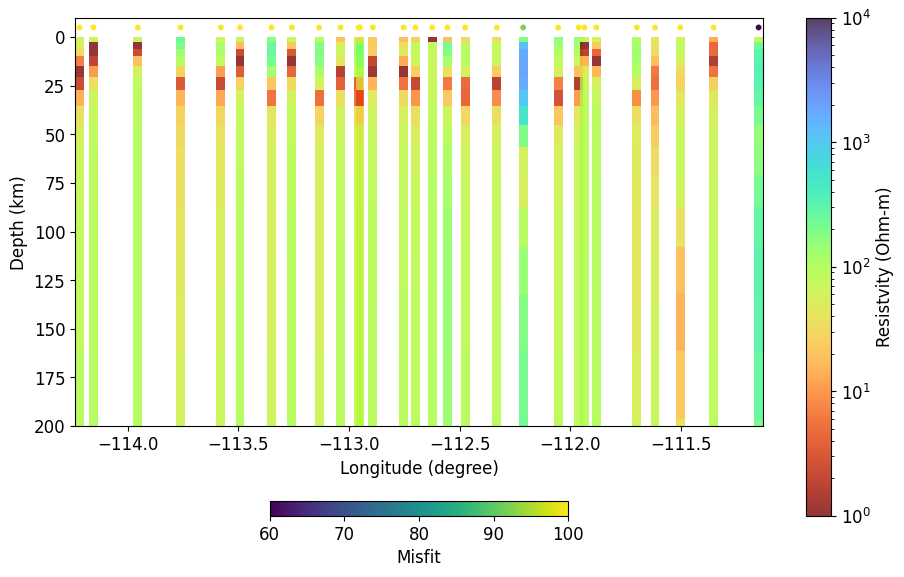

In [14]:
fig = plt.figure(figsize=(10, 6))
for ii in range(len(lon)):
    x_tmp = [lon[ii]-dx, lon[ii]+dx]
    out = plt.pcolormesh(x_tmp, depth/1e3, RHO[ii,::-1].reshape([-1,1]), norm=LogNorm(vmin=1e0, vmax=10000), cmap='turbo_r', alpha=0.8)
out_misfit = plt.scatter(lon, np.ones(len(lon)) * -0.5e1, c=phid_s, s=10, vmin=60, vmax=100)

plt.ylim(200, -1e1)
cb = plt.colorbar(out)
cb.set_label("Resistvity (Ohm-m)")
plt.xlabel("Longitude (degree)")
plt.ylabel("Depth (km)")
cb_mis = plt.colorbar(out_misfit, orientation='horizontal', fraction=0.03)
cb_mis.set_label("Misfit")


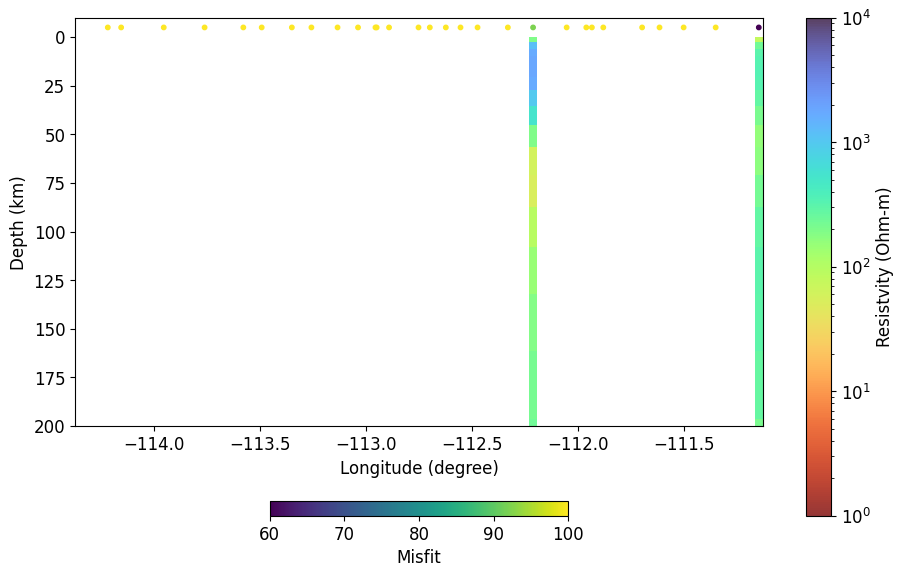

In [15]:
fig = plt.figure(figsize=(10, 6))
inds_bad = []
for ii in range(len(lon)):
    if phid_s[ii]<100:
        x_tmp = [lon[ii]-dx, lon[ii]+dx]
        out = plt.pcolormesh(x_tmp, depth/1e3, RHO[ii,::-1].reshape([-1,1]), norm=LogNorm(vmin=1e0, vmax=10000), cmap='turbo_r', alpha=0.8)
    else:
        inds_bad.append(ii)
out_misfit = plt.scatter(lon, np.ones(len(lon)) * -0.5e1, c=phid_s, s=10, vmin=60, vmax=100)

plt.ylim(200, -1e1)
cb = plt.colorbar(out)
cb.set_label("Resistvity (Ohm-m)")
plt.xlabel("Longitude (degree)")
plt.ylabel("Depth (km)")
cb_mis = plt.colorbar(out_misfit, orientation='horizontal', fraction=0.03)
cb_mis.set_label("Misfit")


In [16]:
# Plot station with a high misfit
# ii = 0
# tf = mc.get_tf(station_ids[inds_bad[ii]])
# tf.plot_mt_response()
# print (phid_s[inds_bad[ii]])